## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 10: Spatio-temporal Gassusian Process (STGP) with Physical Models

A fundamental problem for Gaussian Process is that, many common covariance functions will miss spatial teleconnections such as those associated with sea-level fingerprints or large-scale climate modes, because they assume that correlation decays with distance.

This problem can be efficiently improved by incorporating physical models, which can  add potential information in the open ocean, far from tide gauge sites, whereas purely statistical models lose power away from the data. 

So in this tutorial, we will use a Gaussian Process model along with a glacial isostatic adjustment model to see the difference caused by incorporation of physical models.

This tutorial will be presented in the following order:

**&#10148; 1.** STGP without physical model for Holocene sea-level data

**&#10148; 2.** STGP with a single physical model for Holocene sea-level data

**&#10148; 3.** STGP with multiple physical models for Holocene sea-level data

### 1. STGP without physical model for Holocene sea-level data

As in tutorial 8, we will use sea-level data from Ashe et al., (2019, and references therein) to infer spatio-temporal sea-level change pattern. Unlike tutorial 8 that used a single ST kernel, we will use multiple ST kernels here to decompose different physical processes contribution to sea-level change.


In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os

sys.path.append('../../Code')
import PSTHM 
import time
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

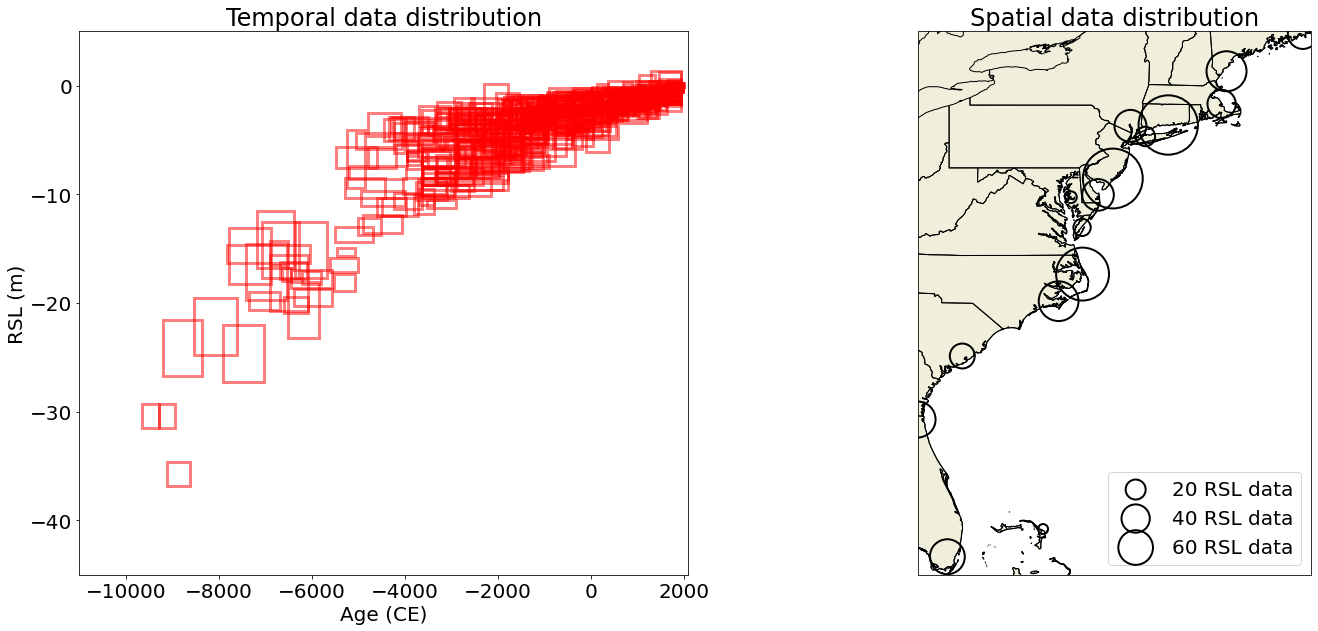

In [3]:
#load data
#ml is marine limiting data, tl is terrestrial limiting data, SLIP is sea-level index points
ml, SLIP, tl = PSTHM.load_regional_rsl_data('../../Data/US_Atlantic_Coast_for_ESTGP.csv')
age, y, y_sigma, age_sigma, rsl_lon,rsl_lat, rsl_region = SLIP
#define input matrix
rsl_coord = torch.tensor(np.vstack((rsl_lat,rsl_lon)).T)
X = torch.hstack([age[:,None],rsl_coord]) 

#--------Plot data distribution----------------
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, :1])
PSTHM.plot_uncertainty_boxes(age,y, age_sigma*2,y_sigma*2,ax=ax)
ax.set_xlim(-11000,2100)
ax.set_ylim(-45,5)
ax.set_title('Temporal data distribution')

#plot spatial data distribution, note that the size of the circle is proportional to the number of data points in the region
ax2 = fig.add_subplot(gs[0, 1:2], projection=ccrs.PlateCarree())

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(rsl_lon),np.max(rsl_lon),np.min(rsl_lat),np.max(rsl_lat)])
rsl_region_index = [np.where(rsl_region==i)[0] for i in np.unique(rsl_region)]
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*20 for x in rsl_region_index],marker='o',facecolor='none',ec='k',
           linewidth=2)
sc = ax2.scatter([0],[0],s=400,label='20 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc2 = ax2.scatter([0],[0],s=800,label='40 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc3 = ax2.scatter([0],[0],s=1200,label='60 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)

ax2.legend(handles=[sc,sc2,sc3], labels=['20 RSL data','40 RSL data','60 RSL data'], loc = 4)

ax2.set_title('Spatial data distribution');

In specific, we will use a global temporal kernel, a regionally linear ST kernel, a regional non-linear ST kernel, a locally non-linear ST kernel and a whitenoise kernel. We can write it down as:

$$
p(f| \Theta_{s},f ) \sim GP(0,k_{combined}(X,X')) \\
k_{combined}(X,X') = k_{global}(t,t') + k_{regionL}(X,X')  + k_{regionNL}(X,X') + k_{localNL}(X,X') + k_{whitenoise}(t,t')$$
where $X$ indicates each specific kernel is: 
$$
k_{global}(t,t') = k_{M_{32}}(t,t')\\
k_{regionL}(X,X') = k_{Linear}(t,t') \cdot k_{RBF}(x,x')\\
k_{regionNL}(X,X') = k_{M_{52}}(t,t') \cdot k_{M_{32}}(x,x')\\
k_{localNL}(X,X') = k_{M_{32}}(t,t') \cdot k_{M_{32}}(x,x')\\
k_{whitenoise}(t,t') = k_{whitenose}(t,t')\\
$$
The difference between regional and local non-linear kernel is specified by different choices in kernels and prior distribtuions. 


**P.S.** 

1. The default code does not train the model, instead, it will load the trained model, which is much faster. If you want to try to train it on your own computer, just de-comment the code. 

2. To use GPU to accelerate the training process with `SVI_NI_optm` function, we need to specific `gpu==True` as well. 

  0%|          | 0/500 [00:00<?, ?it/s]

Execution time: 80.535 s


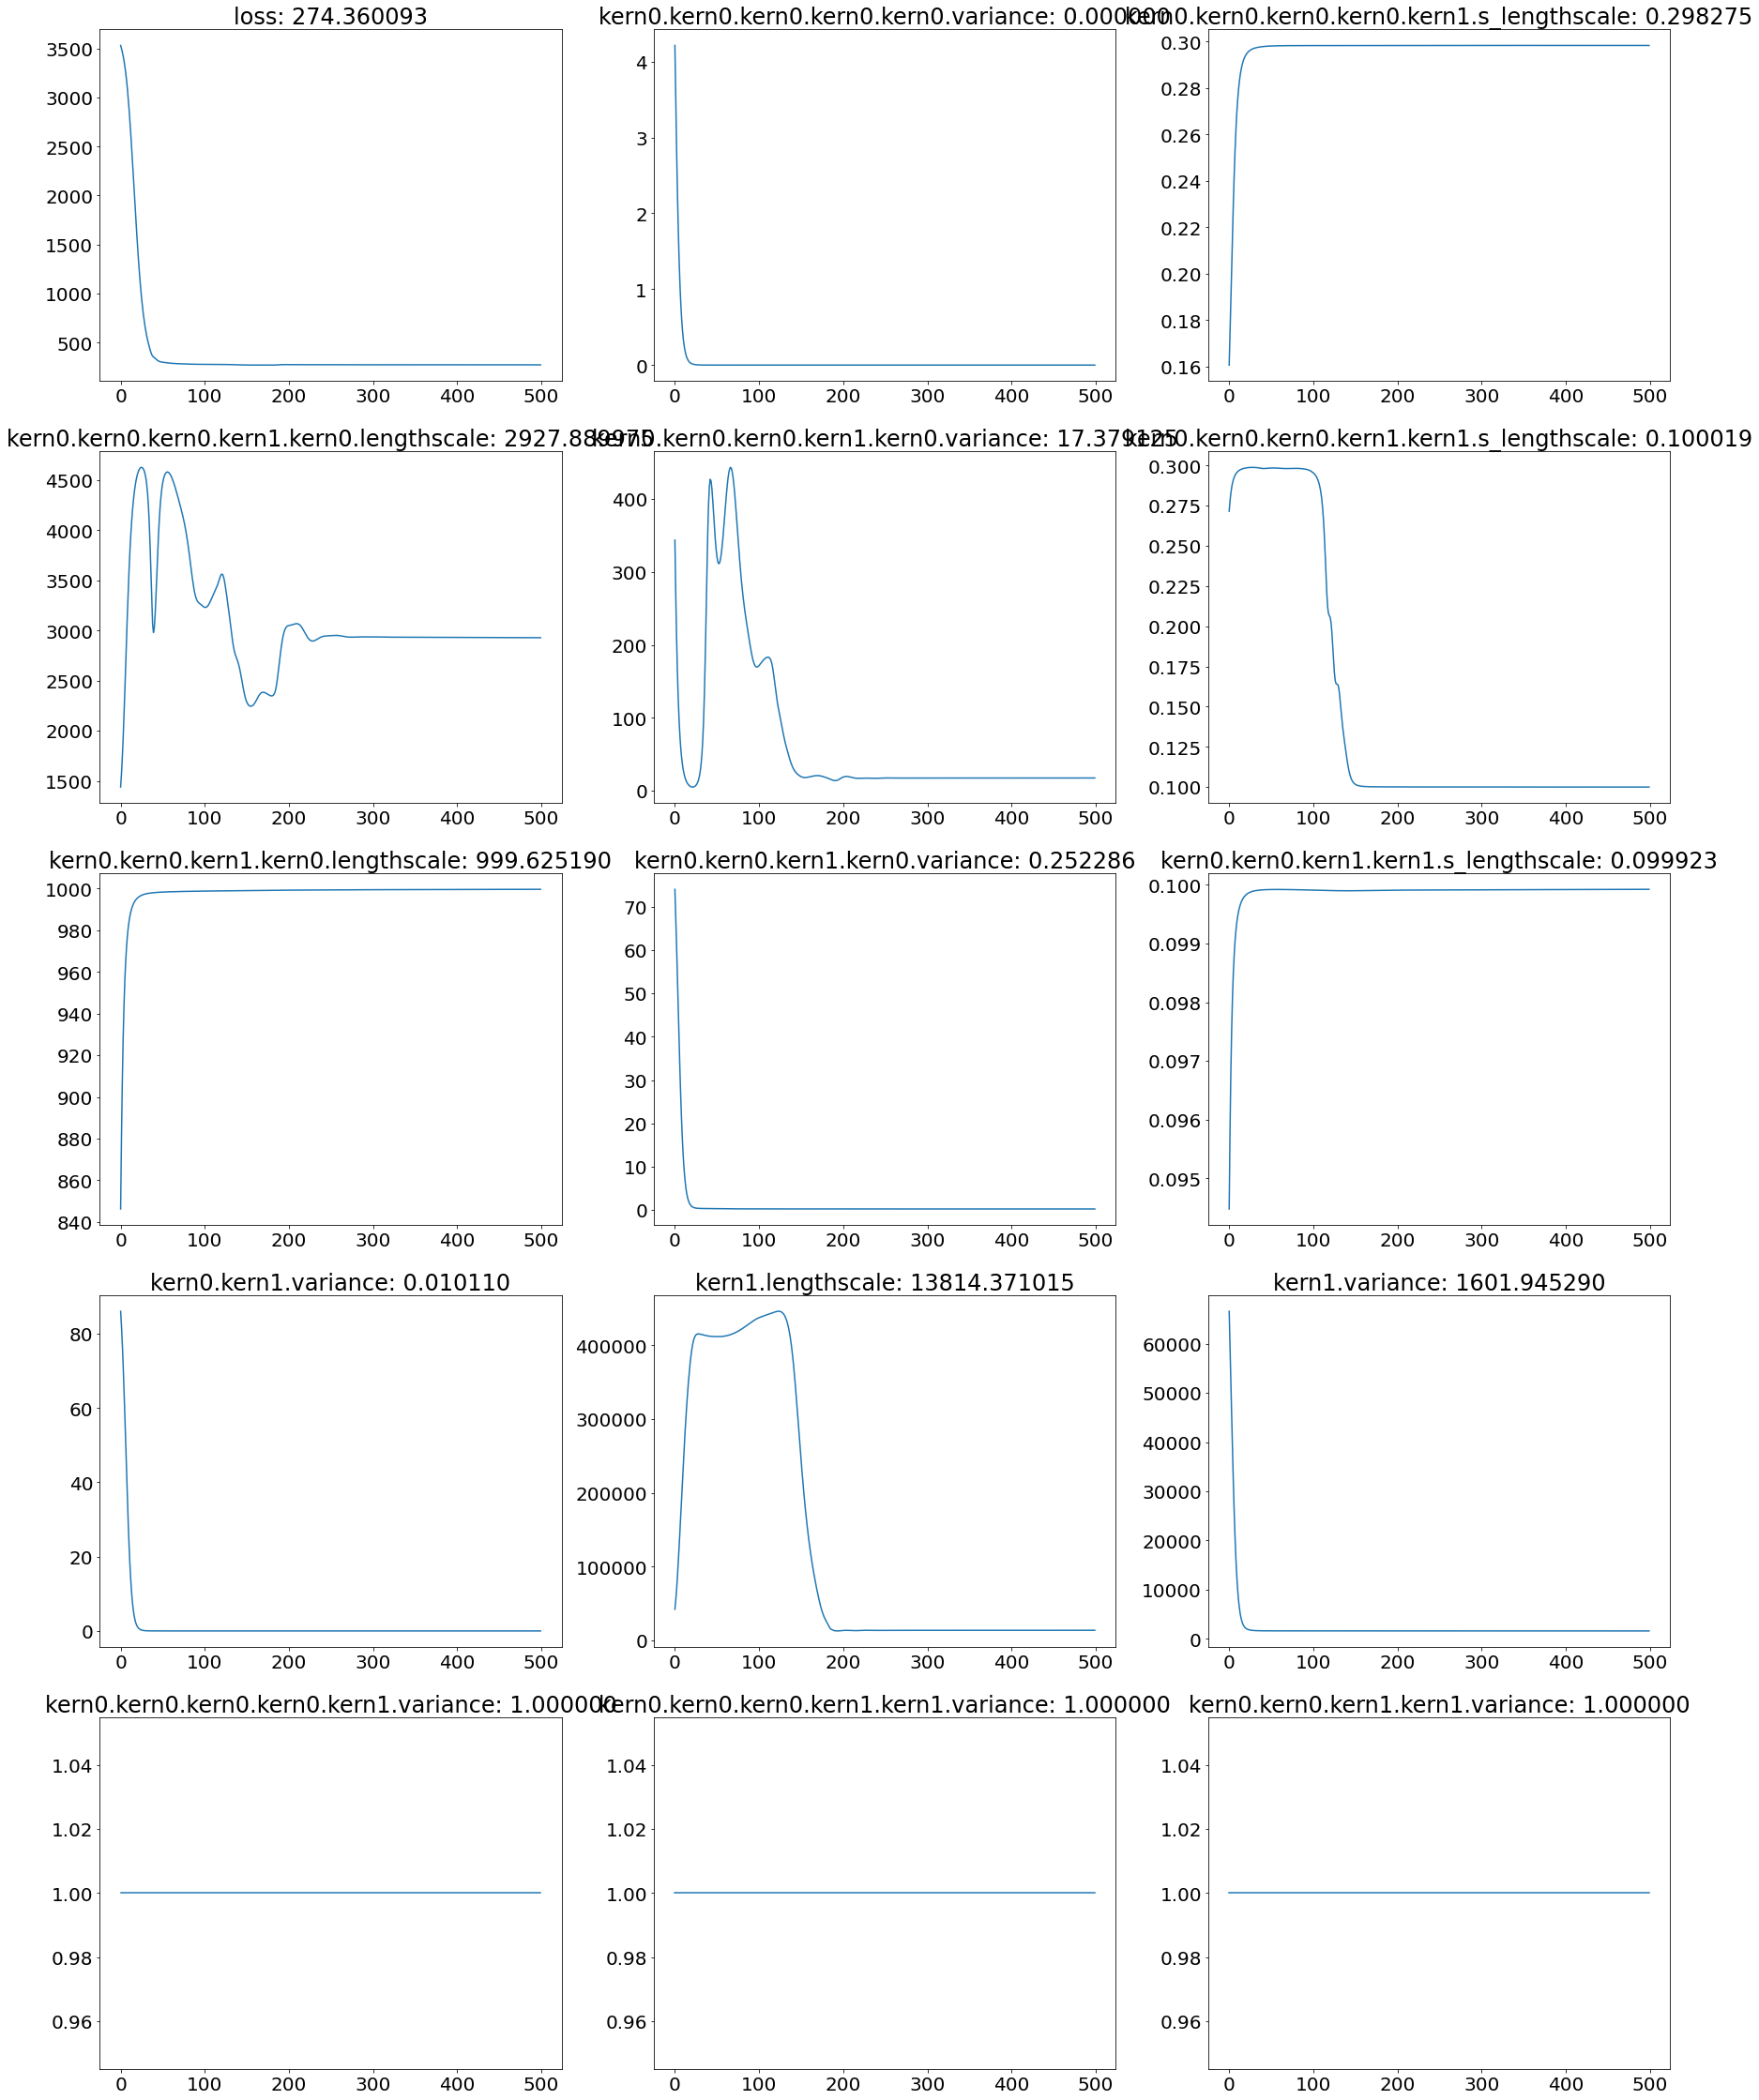

In [11]:
# st = time.time() 

# pyro.clear_param_store()
# #define global temporal kernel as a Matern32
# global_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(5000.), torch.tensor(1000000.)))
# global_kernel.set_prior("variance", dist.Uniform(torch.tensor(40.**2), torch.tensor(100000.)))

# #define regionally linar spatio-temporal kernel
# regional_linear_temporal_kernel = gp.kernels.Linear(input_dim=1)
# regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-12), torch.tensor(10.)))
# regional_linear_spatial_kernel = PSTHM.RBF(input_dim=1,geo=True)
# regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.3)))
# regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

# #define regionally non-linar spatio-temporal kernel
# regional_nl_temporal_kernel = PSTHM.Matern52(input_dim=1,geo=False)
# regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1000.), torch.tensor(5000.)))
# regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.05), torch.tensor(40.**2)))
# regional_nl_spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
# regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.3)))
# regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

# #define locally non-linar spatio-temporal kernel
# local_nl__temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(1000.)))
# local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(10.**2)))
# local_nl__spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
# local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.1)))
# local_nl_kernel = gp.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

# #define whitenoise kernel
# whitenoise_kernel = gp.kernels.WhiteNoise(input_dim=1)
# whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.1**2),torch.tensor(100.)))

# #combine all kernels
# combined_sp_kernel = gp.kernels.Sum(regional_linear_kernel,regional_nl_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,whitenoise_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,global_kernel)

# gpr = PSTHM.GPRegression_V(X.cuda(), y.cuda(), combined_sp_kernel.cuda(),noise=torch.tensor(y_sigma**2).cuda(),jitter=1e-5)
# gpr = gpr.cuda()
# #Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=age_sigma.cuda(),num_iteration=500,lr=0.3,decay_r = 0.8,step_size=100,gpu=True)

# axes = PSTHM.plot_track_list(track_list)
# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format( elapsed_time))

# # #----Save and load the trained model----
# torch.save(gpr, '../../Trained_Models/Holocene_SP_model')
# gpr = torch.load('../../Trained_Models/Holocene_SP_model').cpu()
# gpr.X = gpr.X.cpu()
# gpr.y = gpr.y.cpu()
# gpr.noise = gpr.noise.cpu()

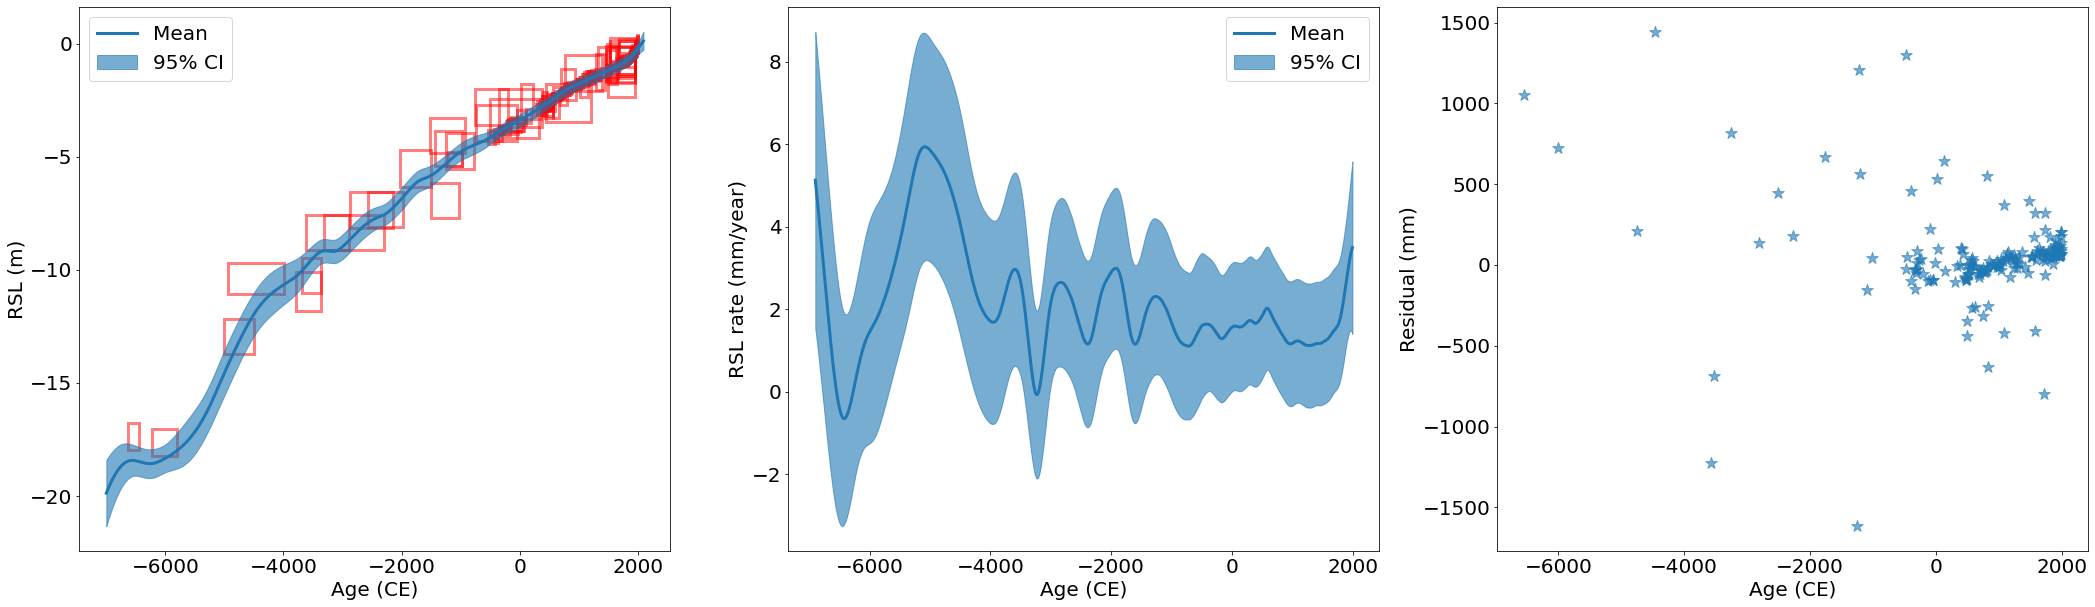

In [13]:
#generate prediction matrix
NJ_index = rsl_region==7
test_age = np.arange(-7000,2100,5)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.cpu().detach().numpy(),y_mean.cpu().detach().numpy())

#plot the prediction
axes = PSTHM.plot_tem_regreesion(age[NJ_index],y[NJ_index],age_sigma[NJ_index],y_sigma[NJ_index],test_age,y_mean.detach().numpy(),y_std.detach().numpy(),
                          rsl_time,rsl_rate,rsl_rate_sd )


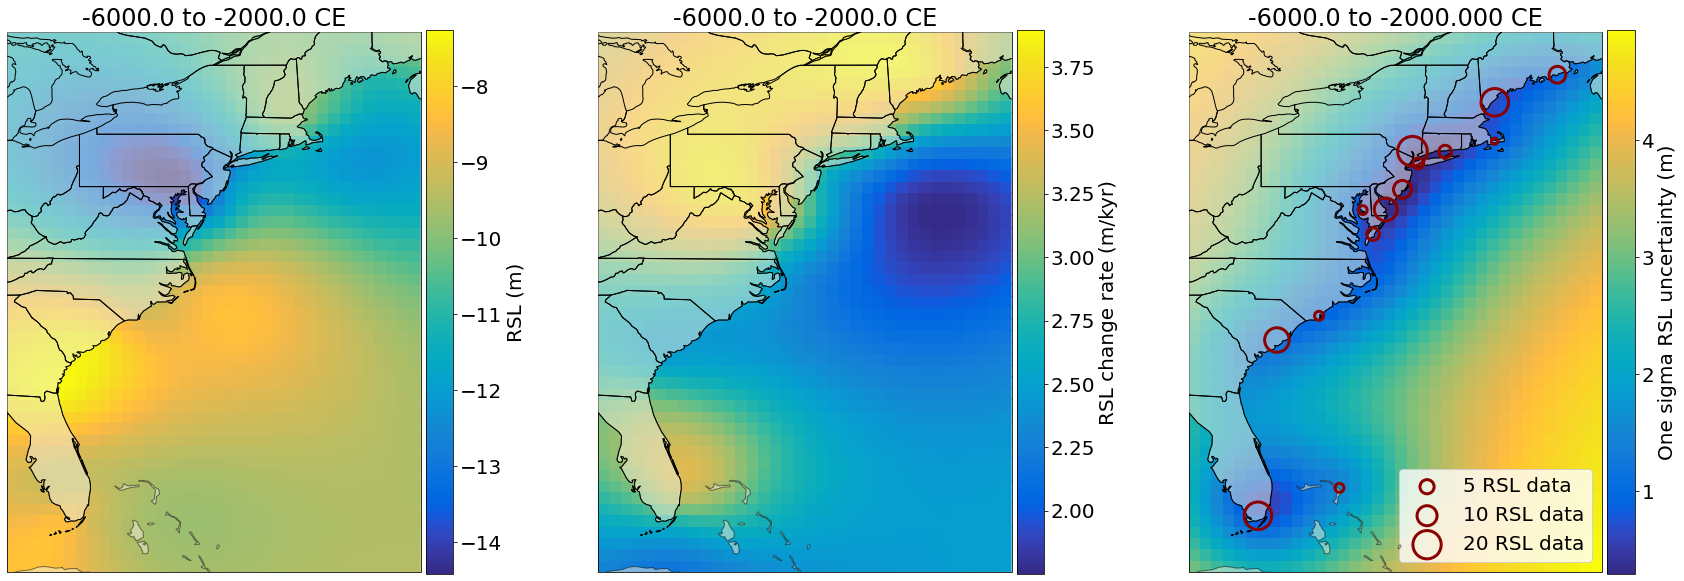

In [14]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
#from 10000 to 8000 with 500 years interval, don't use over small time interval, otherwise the prediction will be very slow
#and the required RAM will be pretty large 
time_mat = np.arange(-6000,-1900,4000) 
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)

y_mean, y_var = gpr(pred_matrix, full_cov=True)

PSTHM.plot_spatial_rsl_range(pred_matrix,y_mean,y_var,rsl_lon,rsl_lat,age,rsl_region,cmap=parula,plot_site=True)


#### Kernel decompositions


In [17]:
NJ_index = rsl_region==7
test_age = np.arange(-10000,2100,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix, full_cov=True)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern1
regional_linear_kernel = gpr.kernel.kern0.kern0.kern0.kern0
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1
local_nl_kernel = gpr.kernel.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep,local_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[global_kernel,regional_linear_kernel,regional_nl_kernel,local_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()

local_nl_mean,local_nl_var = local_nl_dep
local_nl_std = local_nl_var.diag().sqrt()


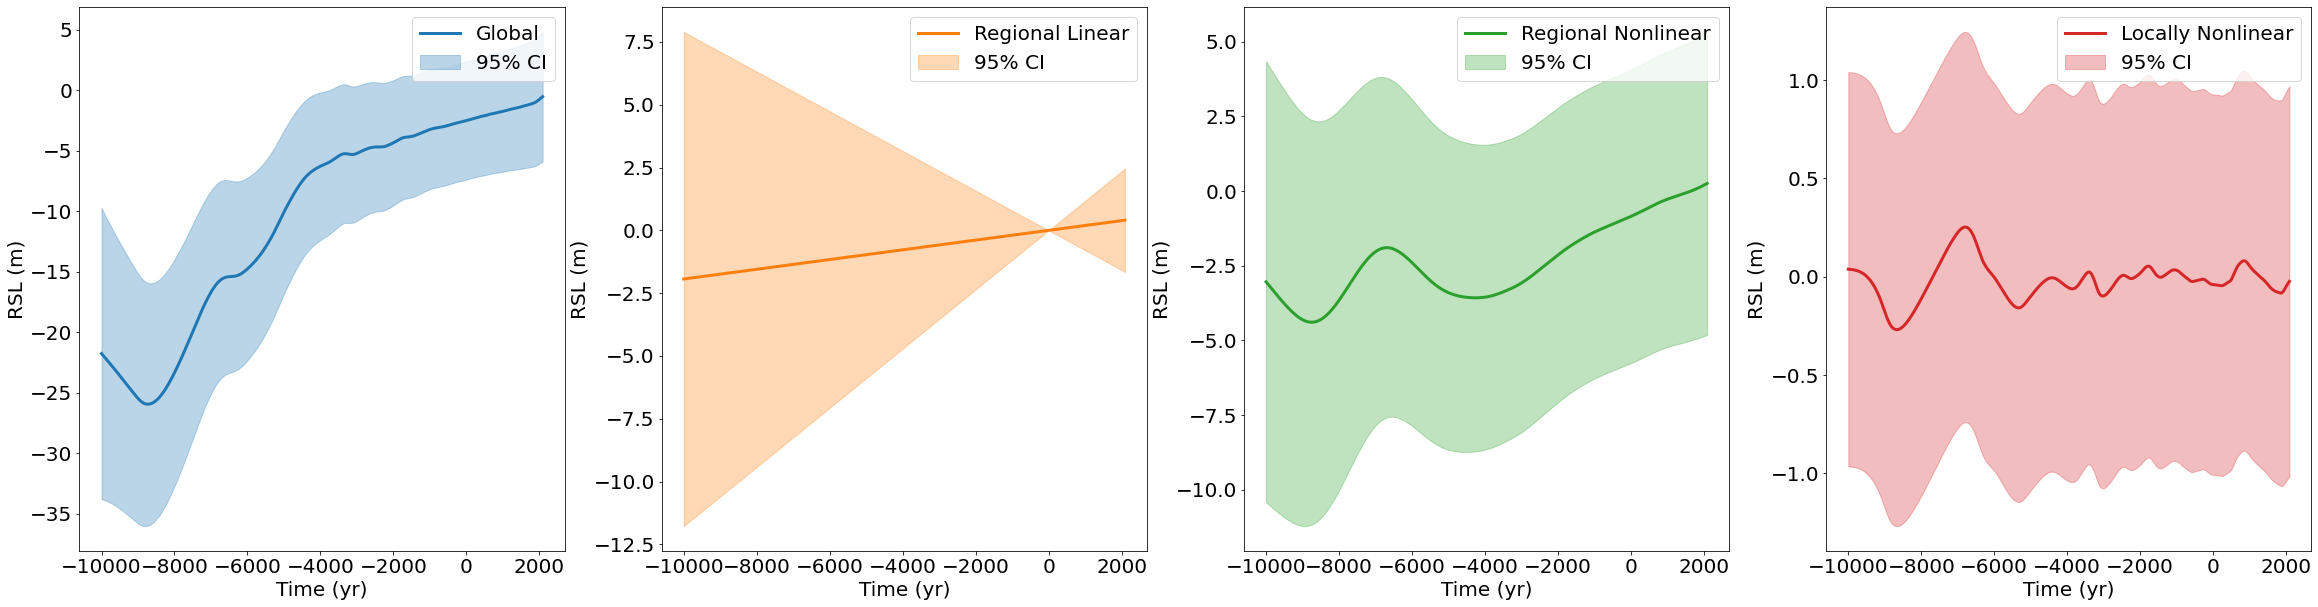

In [18]:
plt.figure(figsize=(40,10))
plt.subplot(141)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(142)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,local_nl_mean.detach().numpy(),'C3',linewidth=3,label='Locally Nonlinear')
plt.fill_between(test_age,local_nl_mean.detach().numpy()-2*local_nl_std.detach().numpy(),local_nl_mean.detach().numpy()+2*local_nl_std.detach().numpy(),color='C3',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend();

In [25]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.gen_pred_matrix([-10000],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.gen_pred_matrix([2000],lat_matrix,lon_matrix)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern1
regional_linear_kernel = gpr.kernel.kern0.kern0.kern0.kern0
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1
local_nl_kernel = gpr.kernel.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
reigonal_linear_dep,regional_nl_dep,local_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[regional_linear_kernel,regional_nl_kernel,local_nl_kernel])
reigonal_linear_dep2,regional_nl_dep2,local_nl_dep2 = PSTHM.decompose_kernels(gpr,pred_matrix2,[regional_linear_kernel,regional_nl_kernel,local_nl_kernel])

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_mean2,regional_linear_var2 = reigonal_linear_dep2
regional_linear_std = regional_linear_var.diag().sqrt()
regional_linear_std2 = regional_linear_var2.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_mean2,regional_nl_var2 = regional_nl_dep2
regional_nl_std = regional_nl_var.diag().sqrt()
regional_nl_std2 = regional_nl_var2.diag().sqrt()

local_nl_mean,locall_nl_var = local_nl_dep
local_nl_mean2,local_nl_var2 = local_nl_dep2
local_nl_std = local_nl_var.diag().sqrt()
local_nl_std2 = local_nl_var2.diag().sqrt()


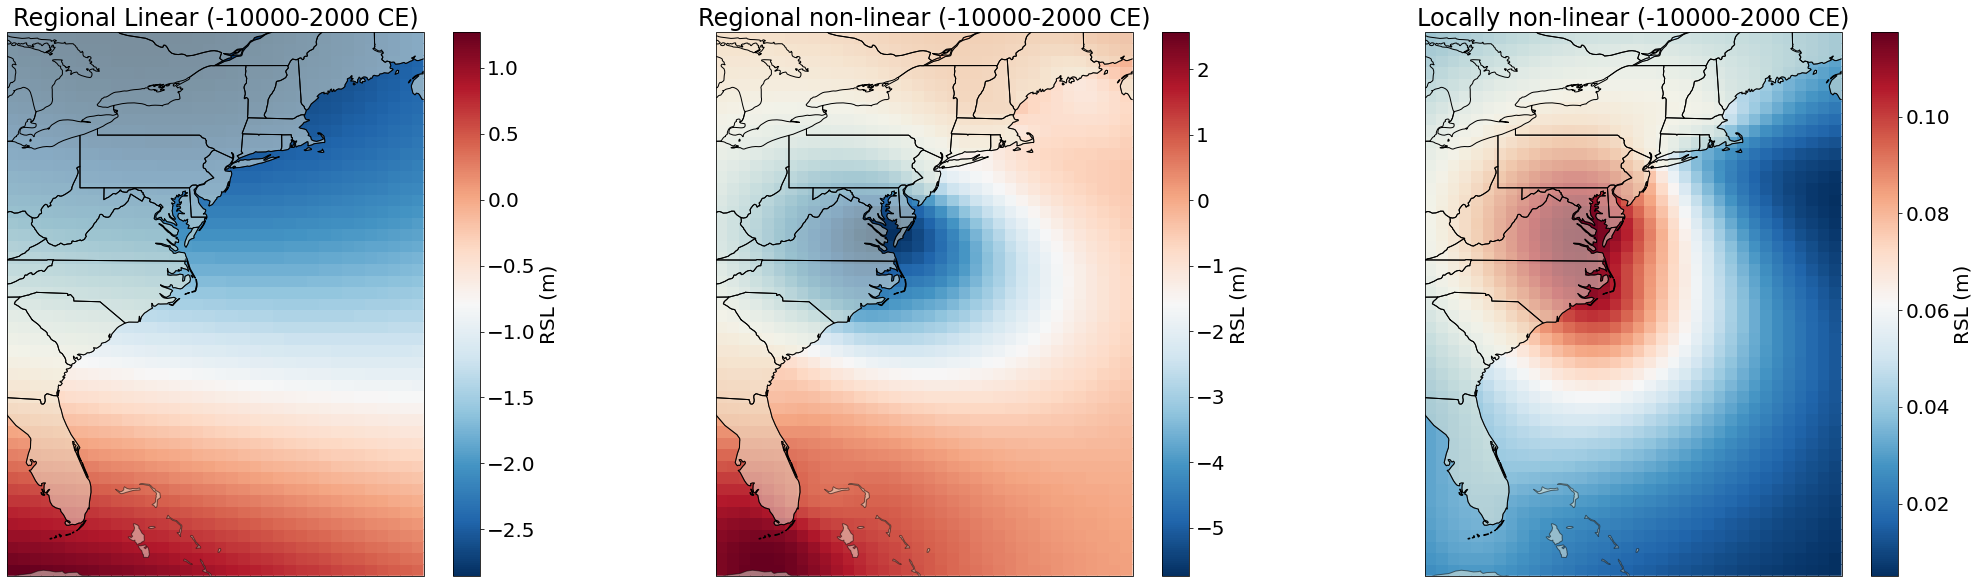

In [26]:
plt.figure(figsize=(36,10))
ax2 = plt.subplot(131,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(regional_linear_mean-regional_linear_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Regional Linear (-10000-2000 CE)')


ax2 = plt.subplot(132,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)

im = ax2.pcolor(lon_mat,lat_mat,(regional_nl_mean-regional_nl_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Regional non-linear (-10000-2000 CE)')

ax2 = plt.subplot(133,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)

im = ax2.pcolor(lon_mat,lat_mat,(local_nl_mean-local_nl_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Locally non-linear (-10000-2000 CE)');

By decomposing different STGP kernels, we can start to identify some phyiscal processes of postglacial sea-level change. We can see that regional linear kernel cause sea-level fall in the north and sea-level rise in the south, which can relate to glacial isostatic adjustment, tectonic and sediment compaction. The regional and locally non-linear terms usually used to describe ocean/atmosphere dynamics and static equilibrium “fingerprint” effects. 

### 3. STGP with a single physical model for Holocene sea-level data

As suggested by many paleo sea-level studies that the majority of sea-level change from the Last Glacial Maximum (~21,000 years ago) can be explained by ice-ocean mass exchange induced gravitational, rotational and deformational effects on sea-level change, whcih can be modelled by a glacial isostatic adjustment model. 